In [1]:
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm


In [6]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, seq_len, dropout=0.1):
        super(TimeSeriesTransformer, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.embedding = nn.Linear(input_dim, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        self.positional_encoding = self._generate_positional_encoding(d_model)
        self.output_layer = nn.Linear(d_model, 1)  # predicting two values: v_Vel and v_Acc

    def forward(self, src):
        src = self.embedding(src) * torch.sqrt(torch.tensor(self.d_model))
        pe = self._generate_positional_encoding(src.size(0))  # generate positional encoding dynamically
        src += pe
        output = self.transformer_encoder(src)
        output = self.output_layer(output[:, -1, :])
        return output

    def _generate_positional_encoding(self, batch_size):
        position = torch.arange(0, self.seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / self.d_model))
        pe = torch.zeros(self.seq_len, self.d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).repeat(batch_size, 1, 1)
        return pe

input_dim = 3  # The number of input features
nhead = 8  # The number of heads in the multi-head attention models
num_encoder_layers = 6  # The number of sub-encoder-layers in the encoder
dim_feedforward = 2048  # The dimension of the feedforward network model
dropout = 0.1  # The dropout value
sequence_length=10
# Ensure d_model is divisible by nhead
d_model = 8 * nhead

model_transformer = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_encoder_layers=num_encoder_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout,
    seq_len=sequence_length
)


LSTM

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size=3
hidden_size = 64
num_layers = 2
output_size = 1
num_epochs = 100
learning_rate = 0.001

model_lstm = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

In [47]:
model = model_transformer
#model = model_lstm

In [42]:
model_l = model_lstm

In [48]:
model.load_state_dict(torch.load('model_weights_single.pth'))

<All keys matched successfully>

In [43]:
model_l.load_state_dict(torch.load('model_weights_lstm.pth'))

<All keys matched successfully>

TEST ON ANY DATASET

In [27]:
def create_sequences(input_data, target_data, sequence_length):
    sequences = []
    targets = []
    for i in range(len(input_data) - sequence_length):
        seq = input_data[i:i+sequence_length]  # Sequence of features
        target = target_data[i+sequence_length]  # Next step's features
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [67]:
# load data for YOLO testing
data = pd.read_csv("final_I80_single_next.csv")
#data = pd.read_csv("final_101_single.csv")
#data = pd.read_csv("final_Peach_single_next.csv")
#data = pd.read_csv("final_LB_single.csv")

batch_size = 64

# Normalize the data (example)
normalized_data = (data - data.mean()) / data.std()

feature_columns = ['x','y','vel']
target_columns = ['vel']

# Create sequences
sequence_length = 10  # For example, using the last 10 timesteps to predict the next

# Convert DataFrame to numpy and split features and target
feature_data = normalized_data[feature_columns].values
target_data = normalized_data[target_columns].values

sequences, targets = create_sequences(feature_data, target_data, sequence_length)

test_sequences, test_targets = sequences, targets

test_sequences = torch.tensor(test_sequences, dtype=torch.float16)
test_targets = torch.tensor(test_targets, dtype=torch.float16)

vehicle_data = TensorDataset(test_sequences, test_targets)
vehicle_loader = DataLoader(vehicle_data, batch_size=batch_size, shuffle=False)

In [72]:
loss_function = torch.nn.MSELoss()  # Mean Squared Error Loss for regression tasks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

# Evaluate on test data
def evaluate(model, test_loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    test_losses = []
    with torch.no_grad():  # No gradients required for testing
        for seq, target in test_loader:
            seq, target = seq.float(), target.float()
            output = model_l(seq)
            loss = loss_function(output, target)
            test_losses.append(loss.item())
    return np.mean(test_losses)

test_loss = evaluate(model, vehicle_loader, loss_function)
print(f'Test Loss: {test_loss:.4f}')

Test Loss: 1.2257


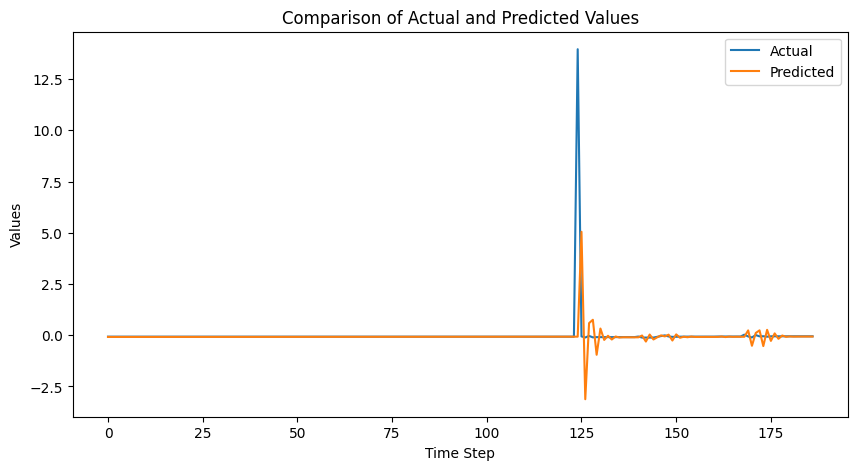

In [73]:
actuals, predictions = [], []

# Function to predict and visualize the results
def plot_predictions(model, loader):
    model.eval()
    with torch.no_grad():
        for seq, target in loader:
            seq, target = seq.float(), target.float()
            output = model_l(seq)
            actuals.extend(target.numpy())
            predictions.extend(output.numpy())

    # Plotting the first few sequences
    plt.figure(figsize=(10, 5))
    plt.plot(actuals, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.title('Comparison of Actual and Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

plot_predictions(model, vehicle_loader)